# (04) Gradients -- Generate & Save

**Motivation**: Following Francesca and Jo's paper. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, Latex

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


sys.path.insert(0, os.path.join(git_dir, 'mapalign'))
from mapalign import embed


def compute_grads(
    mice, mode, desc, band,
    hemis='both',
    use_cos=True, ):
    kws = {
        f"desc_{mode.split('-')[0]}": desc,
        f"band_{mode.split('-')[0]}": band,
    }
    mice.set_kws(**kws)
    a, _ = collect_adjacencies(
        mice=mice,
        mode=mode,
        fill=1.0,
    )
    z = bn.nanmean(np.arctanh(a), 0)
    r = np.nan_to_num(np.tanh(z))
    
    if use_cos:
        norms = np.linalg.norm(r, axis=1, keepdims=True)
        affinity = (r @ r.T) / (norms @ norms.T)
    else:
        affinity = (r + 1) / 2.
    
    if hemis == 'right':
        affinity = affinity[bs.r_idxs][:, bs.r_idxs]
    elif hemis == 'left':
        affinity = affinity[bs.l_idxs][:, bs.l_idxs]
    elif hemis == 'both':
        pass
    else:
        raise ValueError(hemis)

    x, emb_dict = embed.compute_diffusion_map(
        affinity, n_components=bs.num_n, return_result=True)
    x = x.T

    if hemis in ['left', 'right']:
        x_final = np.zeros((len(x), bs.num_n))
        for i, a in enumerate(x):
            x_final[i] = np.tile(a, 2)
        x = x_final
    assert x.shape[1] == bs.num_n
    return x, emb_dict


def get_x2p(g, num=8, zscore=True):
    x2p = np.zeros((3, num, bs.num_n))
    for i, (mode, x) in enumerate(g.items()):
        for j in range(num):
            _x = x[j]
            if zscore:
                x2p[i, j] = sp_stats.zscore(_x)
            else:
                x2p[i, j] = _x
    return x2p


def default_props_anesth(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(512)
    mice.set_kws(
        desc_ca2='preproc',
        desc_bold='rabies-hp',
    )
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca

## Prep

In [3]:
mice = Mice(512)
bs = Base(mice, mode='ca2')
kws_show = show_kws(7)

pal = prepare_palette()
translation = {'BOLD': BOLD, 'CAS': CAS, 'CAF': CAF}

fig_dir = pjoin(fig_base_dir, 'rebuttal')
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal

In [4]:
conds = {
    BOLD: ('bold-lite', 'rabies-hp', (0.01, 0.5)),
    CAS: ('ca2', 'preproc', (0.01, 0.5)),
    CAF: ('ca2', 'preproc', 0.5),
}

## Generate

In [5]:
%%time

grads = collections.defaultdict(dict)
lambs = collections.defaultdict(dict)
for hemis in ['left', 'right', 'both']:
    for k, v in conds.items():
        x, emb_dict = compute_grads(
            mice, *v,
            hemis=hemis,
            use_cos=False,
        )
        grads[hemis][k] = x
        lambs[hemis][k] = emb_dict['lambdas']
        
_ = save_obj(
    obj={'grads': grads, 'lambs': lambs},
    file_name='grads',
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'grads.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 4min 1s, sys: 1min 14s, total: 5min 16s
Wall time: 3min 48s


In [6]:
%%time

grads = collections.defaultdict(dict)
lambs = collections.defaultdict(dict)
for hemis in ['left', 'right', 'both']:
    for k, v in conds.items():
        x, emb_dict = compute_grads(
            mice, *v,
            hemis=hemis,
            use_cos=True,
        )
        grads[hemis][k] = x
        lambs[hemis][k] = emb_dict['lambdas']
        
_ = save_obj(
    obj={'grads': grads, 'lambs': lambs},
    file_name='grads_cos',
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'grads_cos.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 3min 51s, sys: 1min 28s, total: 5min 19s
Wall time: 3min 30s


## Hemis = left

In [7]:
hemis = 'left'

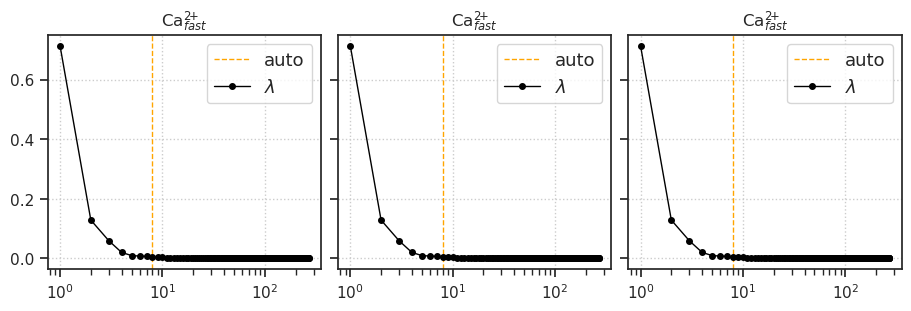

In [8]:
fig, axes = create_figure(1, 3, (9, 3), 'all', 'all', 'constrained')

for i, (ka, v) in enumerate(conds.items()):
    axes[i].axvline(8, color='orange', ls='--', lw=1, label='auto')
    _x2p = lambs[hemis][k]
    _x2p /= _x2p.sum()
    axes[i].plot(
        np.arange(1, len(_x2p) + 1), _x2p, marker='o',
        markersize=4, lw=1, color='k', label=r'$\lambda$')
    axes[i].legend(fontsize=13, loc='best')
    axes[i].set_title(k)
    axes[i].grid()
axes[0].set(xscale='log', yscale='linear')
plt.show()

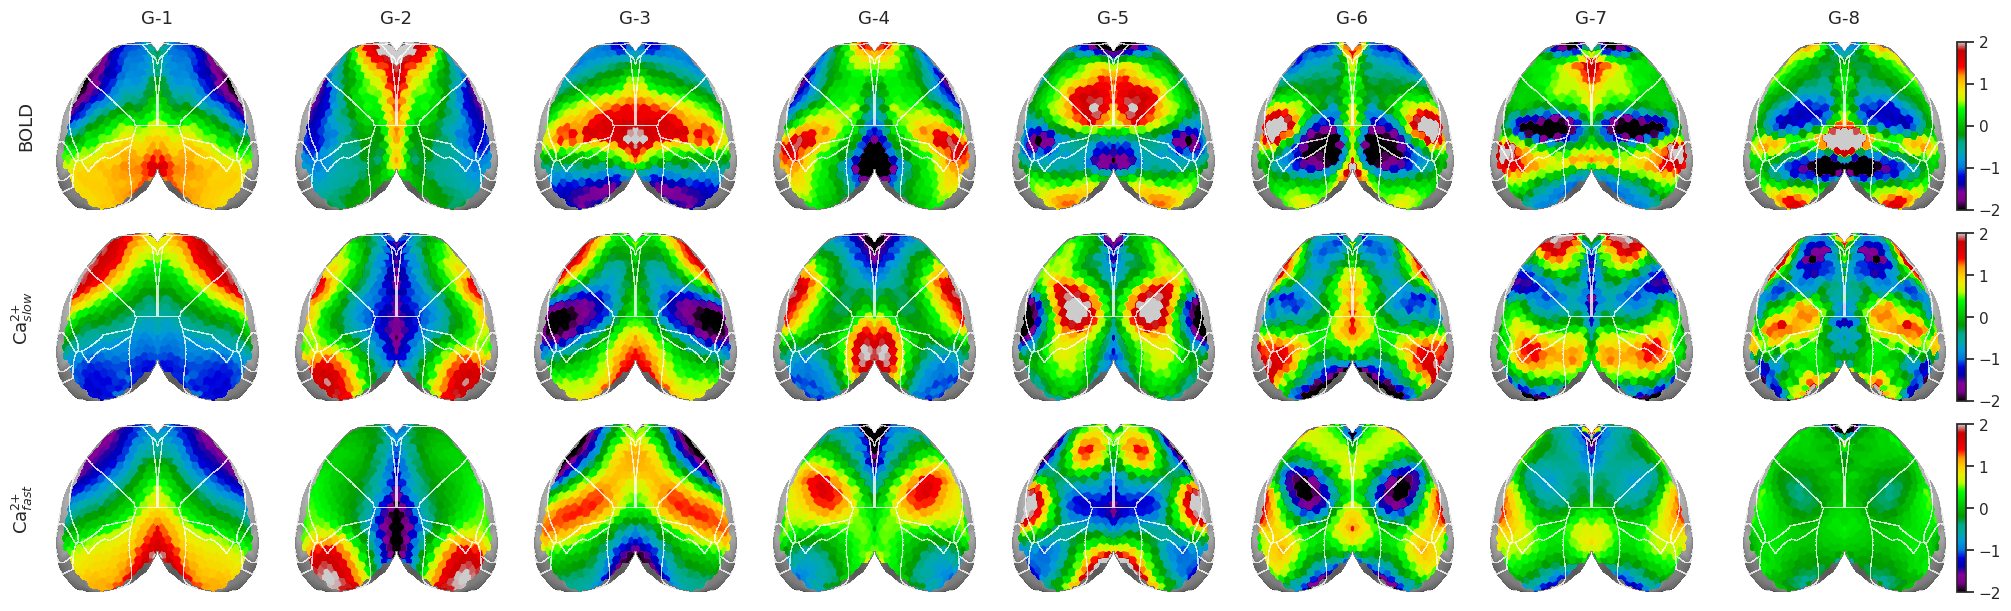

In [9]:
x2p = get_x2p(grads[hemis])

fig, _ = bs.show(
    data={k: x2p[i] for i, k in enumerate(conds)},
    vmin=-2.0, vmax=2.0, figsize=(20, 6),
    titles=[f"G-{i+1}" for i in range(8)],
    cbar=True,
    cmap='nipy_spectral',
    layout='constrained',
)

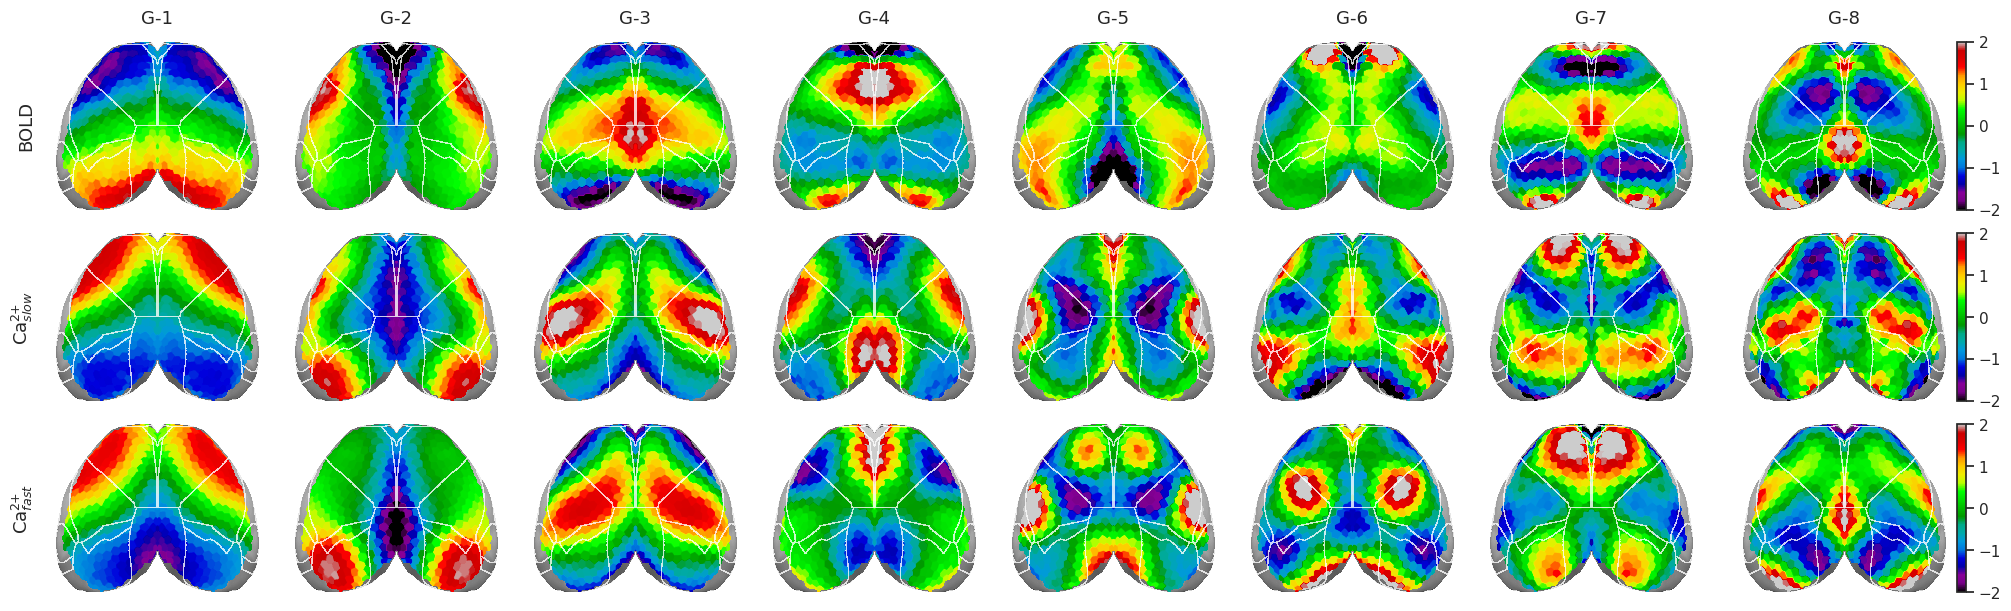

In [9]:
# was (r + 1) / 2

## Hemis = right

In [10]:
hemis = 'right'

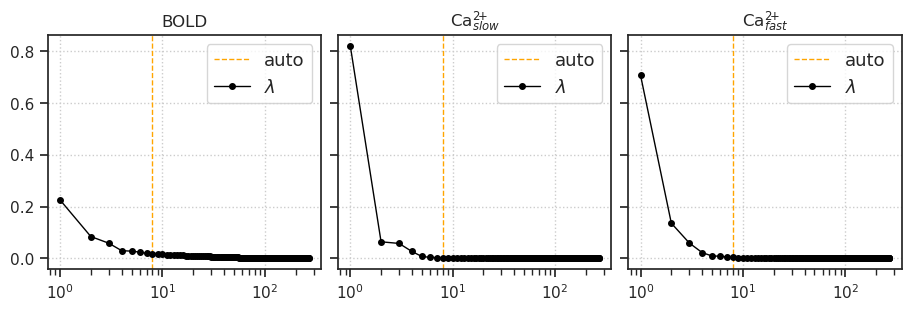

In [11]:
fig, axes = create_figure(1, 3, (9, 3), 'all', 'all', 'constrained')

for i, (k, v) in enumerate(conds.items()):
    axes[i].axvline(8, color='orange', ls='--', lw=1, label='auto')
    _x2p = lambs[hemis][k]
    _x2p /= _x2p.sum()
    axes[i].plot(
        np.arange(1, len(_x2p) + 1), _x2p, marker='o',
        markersize=4, lw=1, color='k', label=r'$\lambda$')
    axes[i].legend(fontsize=13, loc='best')
    axes[i].set_title(k)
    axes[i].grid()
axes[0].set(xscale='log', yscale='linear')
plt.show()

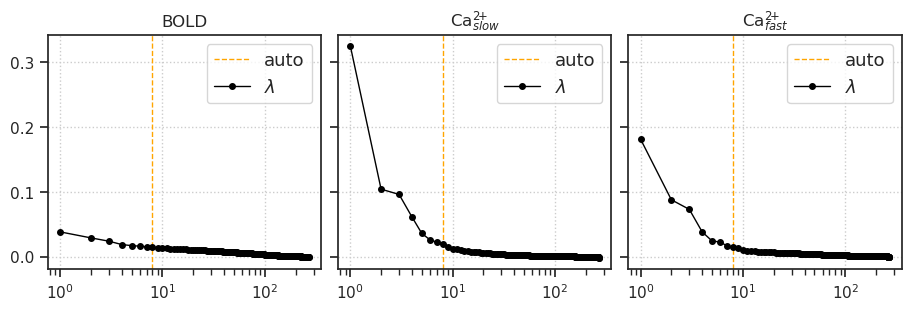

In [11]:
# was (r + 1) / 2

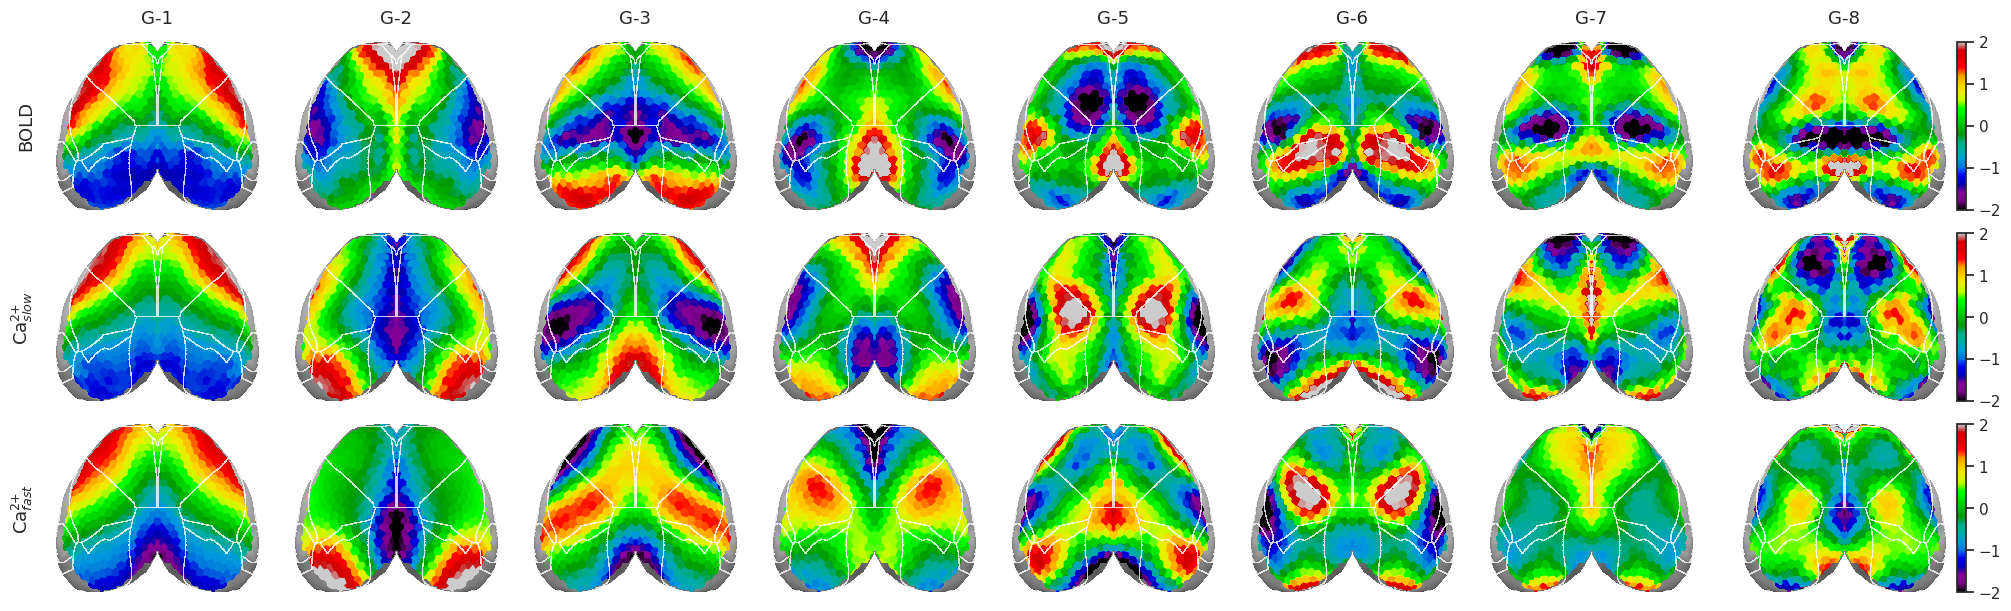

In [12]:
x2p = get_x2p(grads[hemis])

fig, _ = bs.show(
    data={k: x2p[i] for i, k in enumerate(conds)},
    vmin=-2.0, vmax=2.0, figsize=(20, 6),
    titles=[f"G-{i+1}" for i in range(8)],
    cbar=True,
    cmap='nipy_spectral',
    layout='constrained',
)

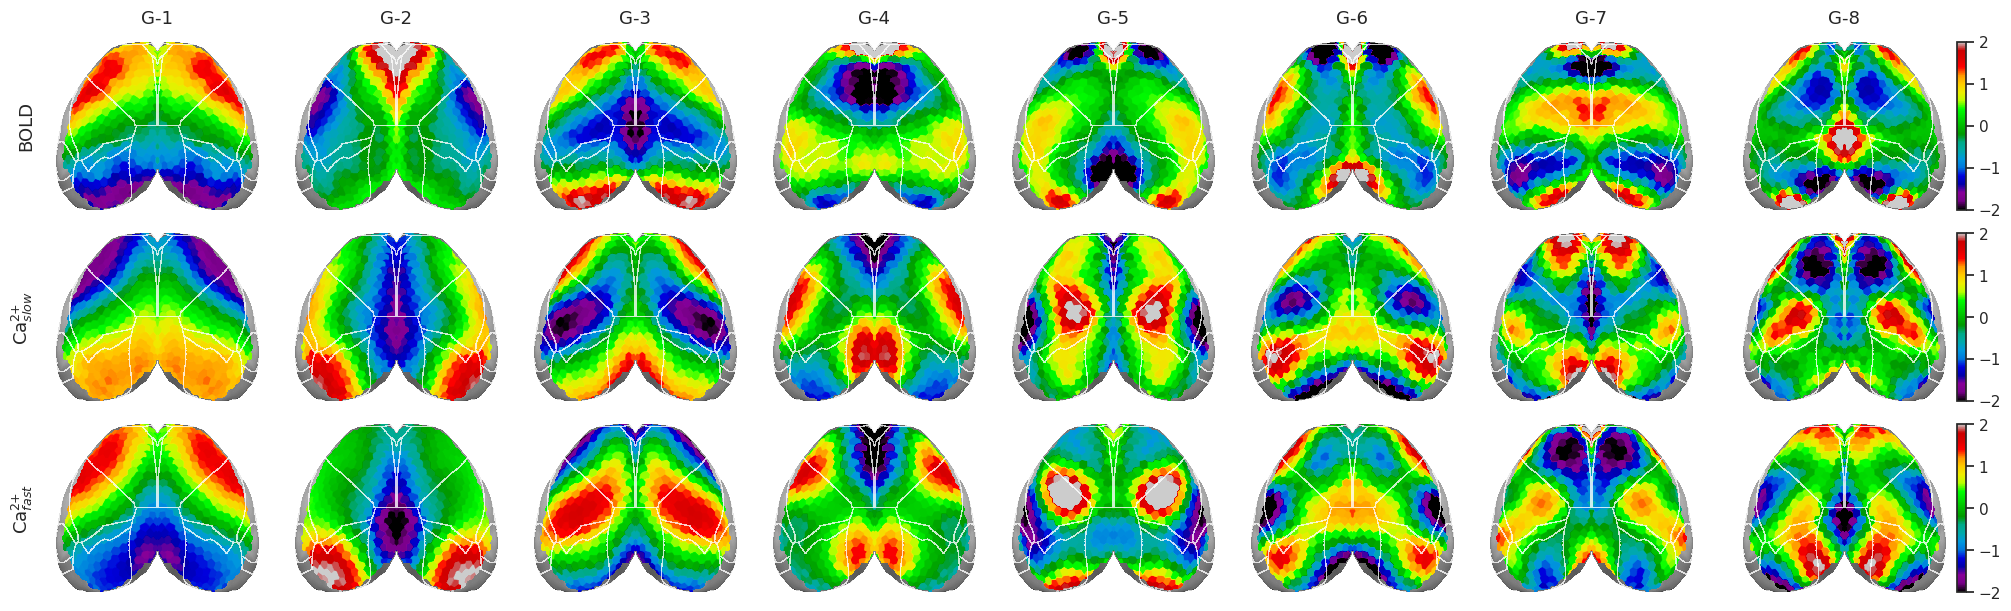

In [12]:
# was (r + 1) / 2

## Hemis = both

In [13]:
hemis = 'both'

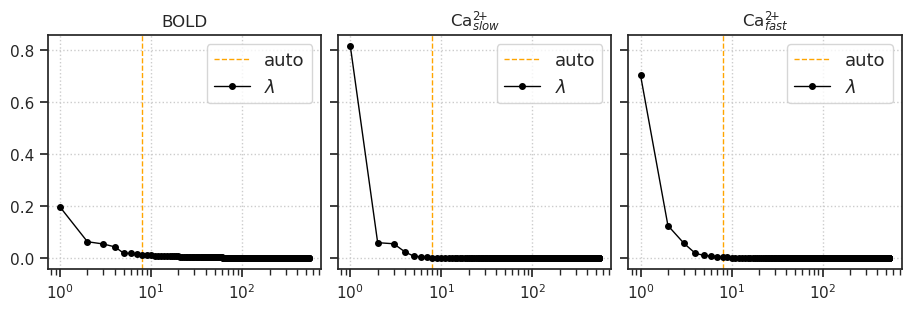

In [14]:
fig, axes = create_figure(1, 3, (9, 3), 'all', 'all', 'constrained')

for i, (k, v) in enumerate(conds.items()):
    axes[i].axvline(8, color='orange', ls='--', lw=1, label='auto')
    _x2p = lambs[hemis][k]
    _x2p /= _x2p.sum()
    axes[i].plot(
        np.arange(1, len(_x2p) + 1), _x2p, marker='o',
        markersize=4, lw=1, color='k', label=r'$\lambda$')
    axes[i].legend(fontsize=13, loc='best')
    axes[i].set_title(k)
    axes[i].grid()
axes[0].set(xscale='log', yscale='linear')
plt.show()

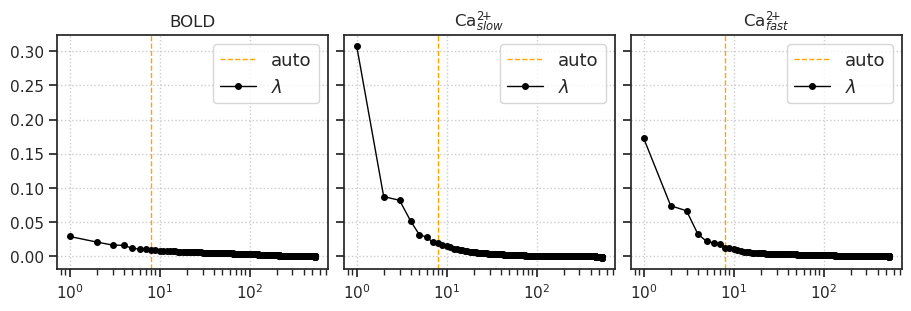

In [14]:
# was (r + 1) / 2

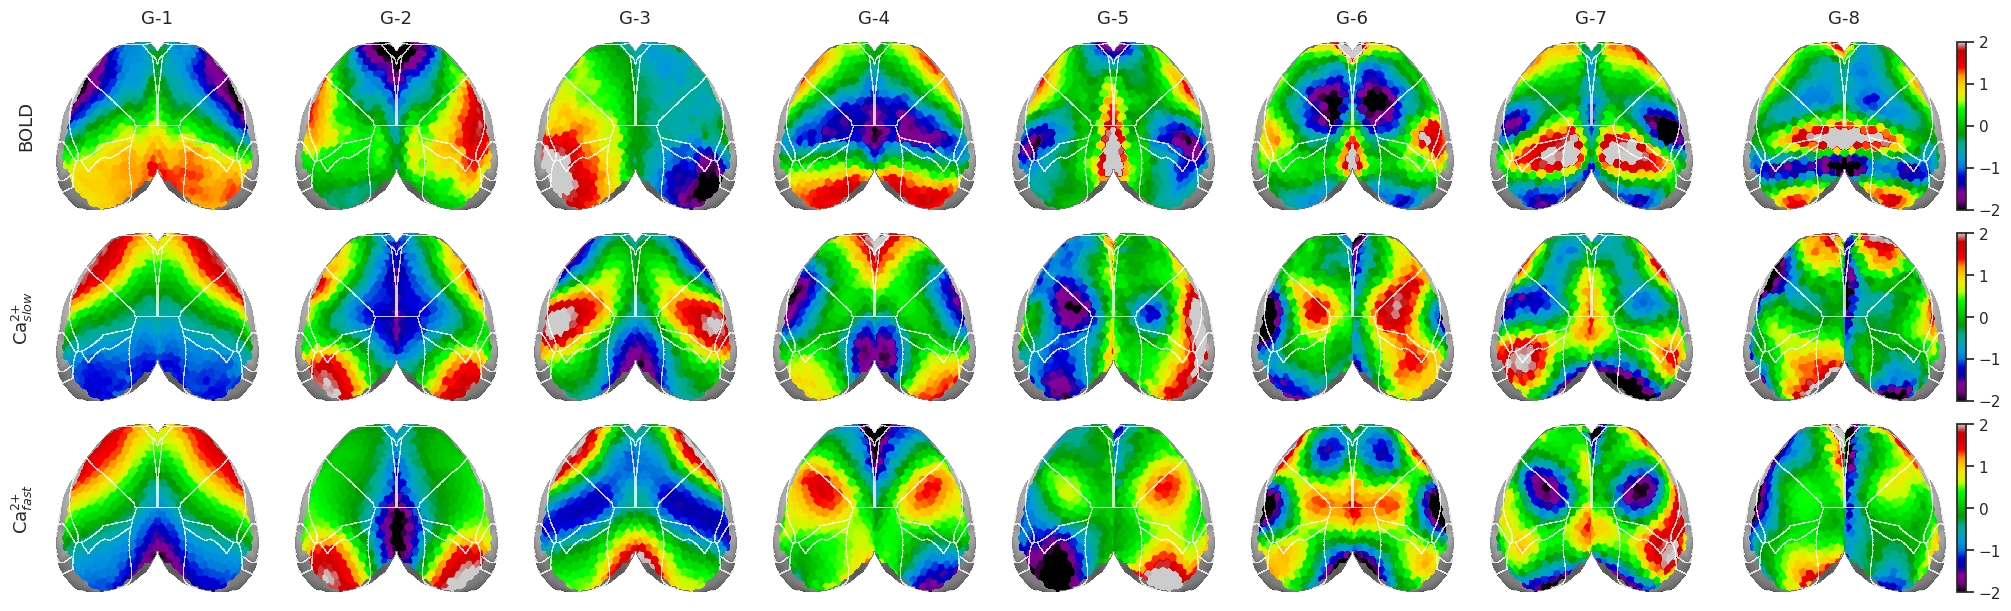

In [15]:
x2p = get_x2p(grads[hemis])

fig, _ = bs.show(
    data={k: x2p[i] for i, k in enumerate(conds)},
    vmin=-2.0, vmax=2.0, figsize=(20, 6),
    titles=[f"G-{i+1}" for i in range(8)],
    cbar=True,
    cmap='nipy_spectral',
    layout='constrained',
)

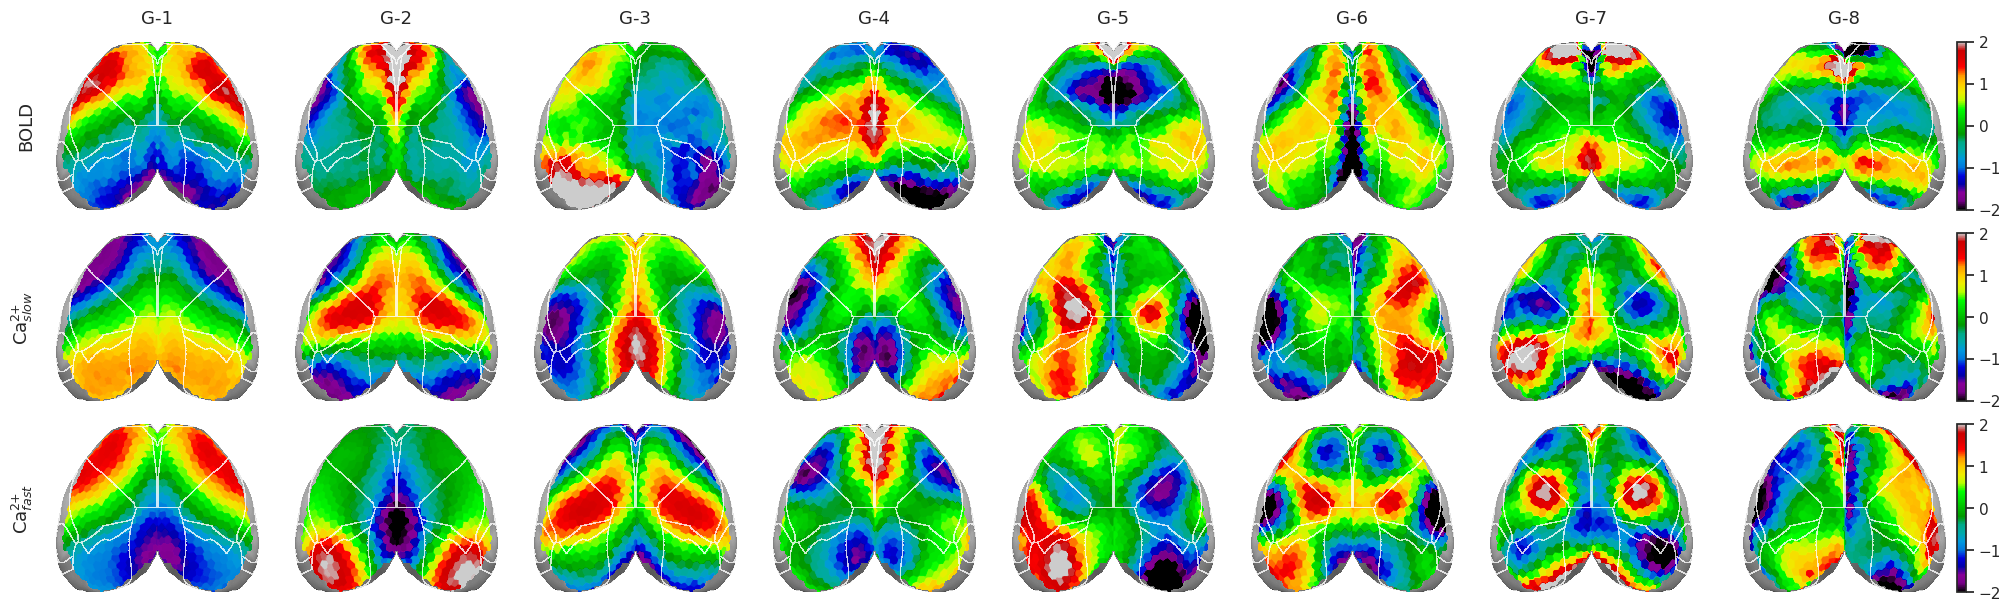

In [15]:
# was (r + 1) / 2

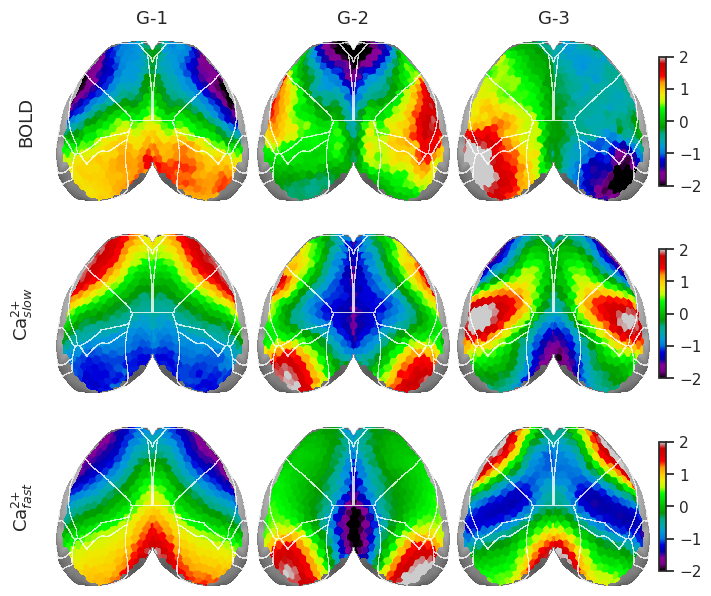

In [17]:
num = 3

x2p = get_x2p(grads['both'], num)
x2p[2, 0] *= -1

fig, _ = bs.show(
    data={k: x2p[i] for i, k in enumerate(conds)},
    vmin=-2.0, vmax=2.0, figsize=(7, 6),
    titles=[f"G-{i+1}" for i in range(num)],
    cbar=True, cbar_shrink=0.7,
    cmap='nipy_spectral',
    layout='constrained',
)

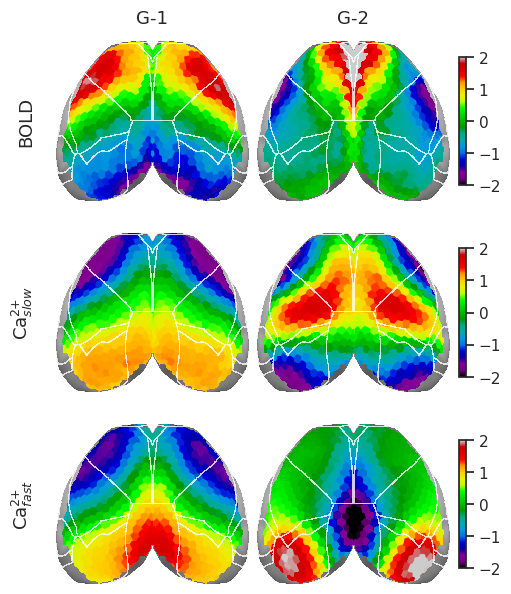

In [16]:
# was (r + 1) / 2

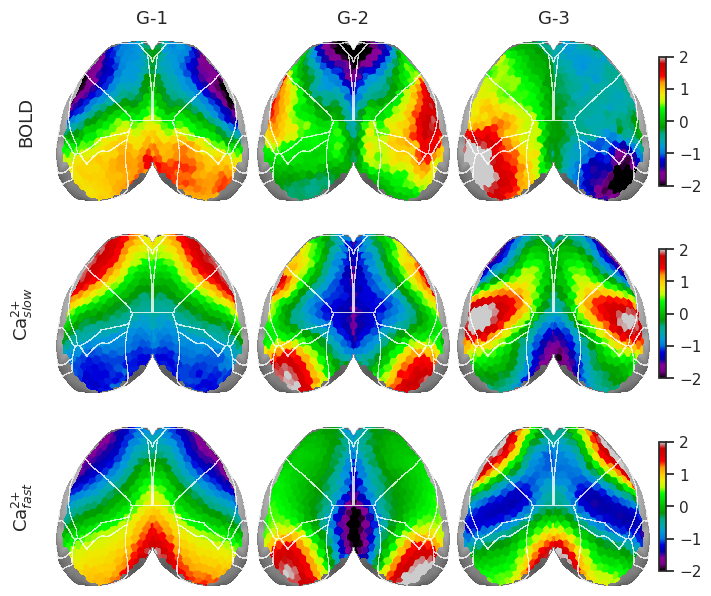

In [18]:
num = 3

x2p = get_x2p(grads['both'], num)
x2p[2, 0] *= -1

fig, _ = bs.show(
    data={k: x2p[i] for i, k in enumerate(conds)},
    vmin=-2.0, vmax=2.0, figsize=(7, 6),
    titles=[f"G-{i+1}" for i in range(num)],
    cbar=True, cbar_shrink=0.7,
    cmap='nipy_spectral',
    layout='constrained',
)

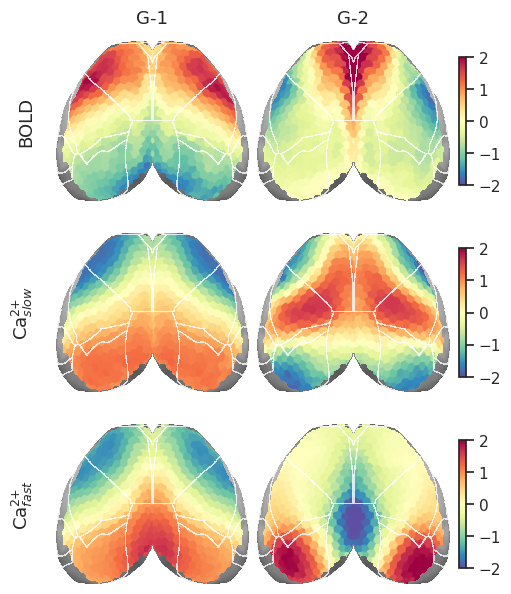

In [17]:
# was (r + 1) / 2